In [1]:
import torch
import clip
from PIL import Image
import pickle
import skimage.io as io
import pandas as pd
from tqdm.auto import tqdm


/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def main(clip_model_type: str, train_mode: str):
    device = torch.device('cuda:0')
    clip_model_name = clip_model_type.replace('/', '_')
    out_path = f"../data/{train_mode}_data.pkl" # custom_path
    clip_model, preprocess = clip.load(clip_model_type, device=device, jit=False)
    train_mode = 'train'
    data_path= f'../data/{train_mode}.csv'
    data = pd.read_csv(data_path)
    print(f"{len(data):0d} captions loaded from csv")
    all_embeddings = []
    all_captions = []
    for i in tqdm(range(len(data))):
        '''
            Index(['img_name', 'img_path', 'mos', 'comments'], dtype='object')
            img_name                                           41wy7upxzl
            img_path                               ./train/41wy7upxzl.jpg
            mos                                                  5.569231
            comments    the pink and blue really compliment each other...
            Name: 0, dtype: object
        '''
        d = data.iloc[i] # Index(['img_name', 'img_path', 'mos', 'comments'], dtype='object')
        img_id = d['img_name']
        file_name = f"../data/{train_mode}/{img_id}.jpg"
        image = io.imread(file_name)
        image = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)
        problematic_files = []  # List to store names of problematic files
        with torch.no_grad():
            prefix = clip_model.encode_image(image).cpu()
        # d['clip_embedding'] = i
        try:
            image = io.imread(file_name)
            image = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)
            with torch.no_grad():
                prefix = clip_model.encode_image(image).cpu()
            all_embeddings.append(prefix)
            if train_mode == "train":
                all_captions.append({'caption' : d['comments'], 'image_name' : img_id, 'clip_embedding' : i})
            else:
                all_captions.append({'image_name' : img_id, 'clip_embedding' : i}) # TODO : 아마 Test Inference에 맞게 pickle 파일을 수정해야 할 듯
        except Exception as e:
            # Handle exceptions for problematic files
            print(f"Error processing file {file_name}: {str(e)}")
            problematic_files.append(file_name)
        # all_embeddings.append(prefix)
        # all_captions.append(d['comments'])
        if (i + 1) % 10000 == 0:
            with open(out_path, 'wb') as f:
                pickle.dump({"clip_embedding" : torch.cat(all_embeddings, dim=0), "captions" : all_captions}, f)
    with open(out_path, 'wb') as f:
        pickle.dump({"clip_embedding" : torch.cat(all_embeddings, dim=0), "captions" : all_captions}, f)
    print('Done')
    print(f"{len(all_embeddings)} embeddings saved")

In [3]:
main('ViT-B/32', 'train')

74568 captions loaded from csv


  3%|▎         | 2161/74568 [01:09<39:00, 30.94it/s]


KeyboardInterrupt: 

In [6]:
data_path= f'../data/train.csv'
data = pd.read_csv(data_path)
for idx, i in tqdm(enumerate(range(len(data)))):
    if idx == 7801 or idx == 19782:
        d = data.iloc[i] # Index(['img_name', 'img_path', 'mos', 'comments'], dtype='object')
        img_id = d['img_name']
        file_name = f"../data/train/{img_id}.jpg"
        image = io.imread(file_name)
        print(file_name)
        

0it [00:00, ?it/s]

../data/train/ek6i3szbl1.jpg
../data/train/v9cljb6bq2.jpg


74568it [00:00, 1279117.51it/s]


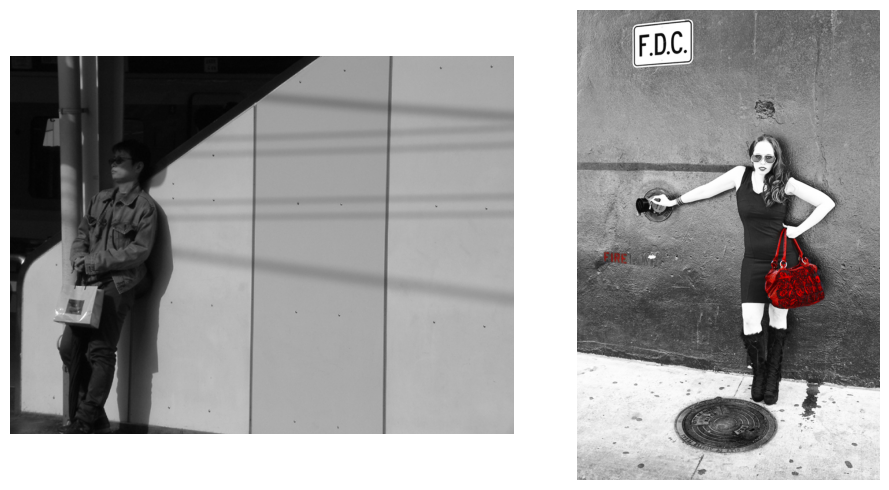

In [14]:
import matplotlib.pyplot as plt
# 이미지 파일 경로 설정
file_paths = [
    '../data/train/ek6i3szbl1.jpg',
    '../data/train/akg0k1k3c6.jpg'
]

# 이미지 시각화
plt.figure(figsize=(10, 5))  # 그림 크기 설정 (가로 10, 세로 5)

for i, file_path in enumerate(file_paths, start=1):
    plt.subplot(1, 2, i)  # 1x2 그리드에서 i번째 서브플롯 선택
    image = io.imread(file_path)
    plt.imshow(image)
    plt.axis('off')  # 축 숨기기

plt.tight_layout()  # 레이아웃 조정
plt.show()
